# **Experiments on synthetic data**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lealagonotte/Geometric_data_analysis_project/blob/raph-colab/experiments/main_diet.ipynb)  
See on Hugging Face: https://huggingface.co/datasets/xingjiepan/PerturbMulti

## **Colab setup**

In [1]:
!git clone https://github.com/lealagonotte/Geometric_data_analysis_project.git
%cd Geometric_data_analysis_project/
!git clone https://github.com/raphaelrubrice/Perturb-OT.git
!git checkout raph-colab

Cloning into 'Geometric_data_analysis_project'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 125 (delta 65), reused 82 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 2.80 MiB | 7.64 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Geometric_data_analysis_project
Cloning into 'Perturb-OT'...
remote: Enumerating objects: 924, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 924 (delta 19), reused 42 (delta 2), pack-reused 851 (from 2)
Receiving objects: 100% (924/924), 38.95 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (129/129), done.
M	Perturb-OT
Branch 'raph-colab' set up to track remote branch 'raph-colab' from 'origin'.
Switched to a new branch 'raph-colab'


In [2]:
!pip install -r requirements-env.txt

Processing ./Perturb-OT/ott (from -r requirements-env.txt (line 4))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Processing ./Perturb-OT/perturbot (from -r requirements-env.txt (line 5))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Processing ./Perturb-OT/scvi-tools (from -r requirements-env.txt (line 6))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of equinox to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at mul

YOU WILL NEED TO RESTART THE SESSION AFTER THE PREVIOUS CELL.
After restarting you should have a working env.

Let's check that we have succesfully recreated the env

In [1]:
import sys, gc

import perturbot.match
import perturbot.predict
from perturbot.match import (
    get_coupling_cotl,
    get_coupling_cotl_sinkhorn,
    get_coupling_egw_labels_ott,
    get_coupling_egw_all_ott,
    get_coupling_eot_ott,
    get_coupling_leot_ott,
    get_coupling_egw_ott,
    get_coupling_cot,
    get_coupling_cot_sinkhorn,
    get_coupling_gw_labels,
    get_coupling_fot,
)
from perturbot.predict import train_mlp
from perturbot.eval.prediction import get_evals, get_evals_preds
from perturbot.eval.match import get_FOSCTTM_single, get_FOSCTTM
import ot
print("Imports succeeded")

Imports succeeded


## **Imports**

In [2]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme("paper")
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from scanpy.preprocessing import subsample

import itertools, time, os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold

## **Download the data**

In [3]:
%cd Geometric_data_analysis_project/
!mkdir data
%cd data
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/RNA_scaled_diet_conditions_20240411.h5ad
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/protein_intensities_diet_conditions_20240411.h5ad

/content/Geometric_data_analysis_project
/content/Geometric_data_analysis_project/data
--2025-12-07 08:18:35--  https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/RNA_scaled_diet_conditions_20240411.h5ad
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/680ec5cec4756876c4befb83/97e210f08666db8f77166e12b71bdfb60cebbe3482271042fe5edce510f8ee78?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27RNA_scaled_diet_conditions_20240411.h5ad%3B+filename%3D%22RNA_scaled_diet_conditions_20240411.h5ad%22%3B&Expires=1765099115&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY1MDk5MTE1fX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjgwZWM1Y2VjNDc1Njg3NmM0YmVmYjgzLzk3ZTIxMGYwODY2NmRiOGY3NzE2Nm

In [4]:
%cd /content/Geometric_data_analysis_project/

/content/Geometric_data_analysis_project


## **Load & process data**

In [5]:
path_rna_diet = "./data/RNA_scaled_diet_conditions_20240411.h5ad"
rna_diet = ad.read_h5ad(path_rna_diet)

In [6]:
rna_diet.obs.head()

,fov,x,y,z,area,cond,batch
id,,,,,,,
100001368350601220443305171011375780801,717,6666.830785,7236.949846,0,296.588262,adlib,IE29
100001800432857001134785976606575060287,849,8413.609407,7209.004054,9,28.819318,adlib,IE29
100002804203690621291738422225750332629,659,6218.665741,3959.272899,6,47.580965,adlib,IE29
100003573867315829655028318295181964954,478,4796.646369,2362.160563,0,596.398900,adlib,IE29
100008668971788868972348129958710863790,885,8984.942123,4629.471220,3,31.794475,adlib,IE29


In [7]:
path_prot_diet = "./data/protein_intensities_diet_conditions_20240411.h5ad"
prot_diet = ad.read_h5ad(path_prot_diet)

In [8]:
prot_diet.obs.head()

,cell_id,condition,cell_name,fov,x,y,z,area,cond,batch,n_genes,n_counts,datatype,leiden,new_leiden,new_leiden_relabeled,cell_type,cluster_type,cell_type_color,cluster_type_color
0,0,adlib_T cell,92741088075053779116951994856866301126,631,10487.513193,125.414363,1,288.918642,adlib,2,79,409.0,merfish,16,2,5,T cell,T cell,8,15
1,1,adlib_T cell,133524280519918220907967806861786402321,847,8363.706168,6825.614590,0,342.417939,adlib,1,49,184.0,merfish,16,2,5,T cell,T cell,8,15
2,2,adlib_T cell,116603158813595984705504213443274415416,781,12026.084383,855.943716,4,52.808116,adlib,2,30,113.0,merfish,16,2,5,T cell,T cell,8,15
3,3,adlib_T cell,317866311329856700012086944685408447975,272,3096.611149,2092.912335,5,123.233572,adlib,1,63,292.0,merfish,16,2,5,T cell,T cell,8,15
4,4,adlib_T cell,150257798544309436723007524508073422512,654,6152.449135,7133.888484,0,96.995168,adlib,1,24,53.0,merfish,16,2,5,T cell,T cell,8,15


In [9]:
GENES = list(rna_diet.var.index)
PROTEINS = list(prot_diet.var.index)
CONDITIONS = list(np.unique(rna_diet.obs['cond']))

In [10]:
print(f"Number of Genes: {len(GENES)}")
print(f"Number of Proteins: {len(PROTEINS)}")
print(f"Number of conditions: {len(CONDITIONS)} ({CONDITIONS})")

Number of Genes: 260
Number of Proteins: 18
Number of conditions: 3 (['adlib', 'fasted', 'hfd'])


In [11]:
print("Maximum expression", np.max(rna_diet.X))
print("Minimum expression", np.min(rna_diet.X))

Maximum expression 10.0
Minimum expression -0.7879467953842848


In [12]:
print("Maximum intensity", np.max(prot_diet.X))
print("Minimum intensity", np.min(prot_diet.X))

Maximum intensity nan
Minimum intensity nan


In [13]:
print("There are nans:", np.isnan(prot_diet.X).sum())

There are nans: 36


In [14]:
nan_mask_rowise = np.where(np.isnan(prot_diet.X).sum(axis=1) > 0, True, False)
print(f"These nans come from {nan_mask_rowise.sum()} rows")
prot_diet.X[nan_mask_rowise,:]

These nans come from 2 rows


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]])

Let's remove these rows

In [15]:
prot_diet_noNA = prot_diet[~nan_mask_rowise,:]
print("Maximum intensity", np.max(prot_diet_noNA.X))
print("Minimum intensity", np.min(prot_diet_noNA.X))

Maximum intensity 0.8667076230049133
Minimum intensity 0.004974730312824249


In [16]:
prot_diet.obs["cond"].value_counts() / prot_diet.shape[0]

,count
cond,
adlib,0.352573
fasted,0.329616
hfd,0.317811


In [17]:
rna_diet.obs["cond"].value_counts() / rna_diet.shape[0]

,count
cond,
adlib,0.364393
fasted,0.322702
hfd,0.312905


All three diets are quite well balanced in the dataset.  
For the remaining cells we will use a subset of the data where only a fraction of cells of each conditions are used for speed purposes.

In [18]:
def condition_subsample(adata, frac, cond_col):
    all_conditions = np.unique(adata.obs[cond_col])
    adata_list = []
    for cond in all_conditions:
        cond_adata = adata[adata.obs[cond_col] == cond]
        adata_list.append(subsample(cond_adata,frac,copy=True))
    return ad.concat(adata_list, axis=0)

FRAC = 0.01

In [19]:
sub_rna_diet = condition_subsample(rna_diet, FRAC, 'cond')
sub_rna_diet

AnnData object with n_obs × n_vars = 7404 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'

In [20]:
del rna_diet
gc.collect()

760

In [21]:
sub_prot_diet = condition_subsample(prot_diet, FRAC, 'cond')
sub_prot_diet

AnnData object with n_obs × n_vars = 5009 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'

In [22]:
del prot_diet
gc.collect()

548

We can check that condition proportions are respected

In [23]:
sub_rna_diet.obs['cond'].value_counts() / sub_rna_diet.shape[0]

,count
cond,
adlib,0.364398
fasted,0.322663
hfd,0.312939


In [24]:
sub_prot_diet.obs['cond'].value_counts() / sub_prot_diet.shape[0]

,count
cond,
adlib,0.352565
fasted,0.329607
hfd,0.317828


## **Visualize data**

Great, now let's visualize our data with UMAP

In [25]:
def pca_data(adata):
    # Computing reduced dimension
    print("Reducing dimension..")
    sc.tl.pca(adata, n_comps=20)
    print("Plotting PCA Variance ratios..")
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=False)

def plot_umap(adata, cond_col,
              reduce_data=True,
              n_neighbors=15,
              metric='euclidean',
              min_dist=0.1,
              spread=1.0,
              addon=''):
    if reduce_data:
        pca_data(adata)
    # Obtain neighbors
    print("Obtaining neighbors..")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric=metric)
    # Compute umap
    print("Computing UMAP..")
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    # Plot
    print("Plotting..")
    sc.pl.umap(adata,
               color=cond_col,
               title=f"Dataset ({addon} modality) colored by diet condition",
               save=f"Our_UMAP_Diet_{addon}.pdf")

Reducing dimension..
Plotting PCA Variance ratios..


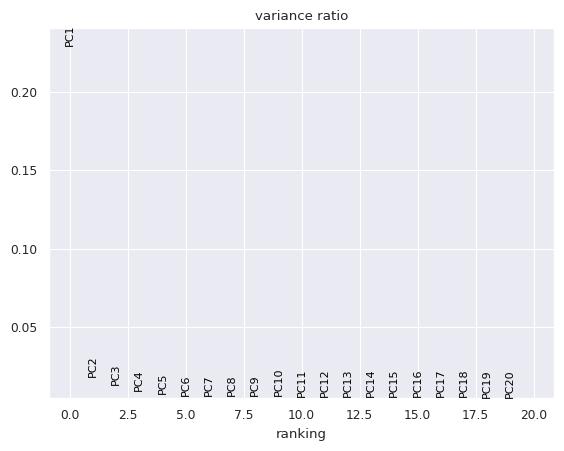

Obtaining neighbors..
Computing UMAP..
Plotting..


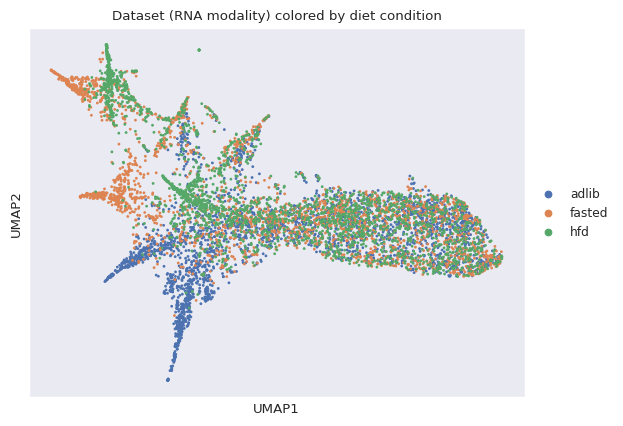

In [26]:
plot_umap(sub_rna_diet, 'cond',
          reduce_data=True,
          n_neighbors=15,
          metric='euclidean',
          min_dist=0.1,
          spread=1.0,
          addon='RNA')

In [27]:
sub_rna_diet

AnnData object with n_obs × n_vars = 7404 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'
    uns: 'pca', 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
sub_rna_diet.obsm['X_pca'].shape

(7404, 20)

Obtaining neighbors..
Computing UMAP..
Plotting..


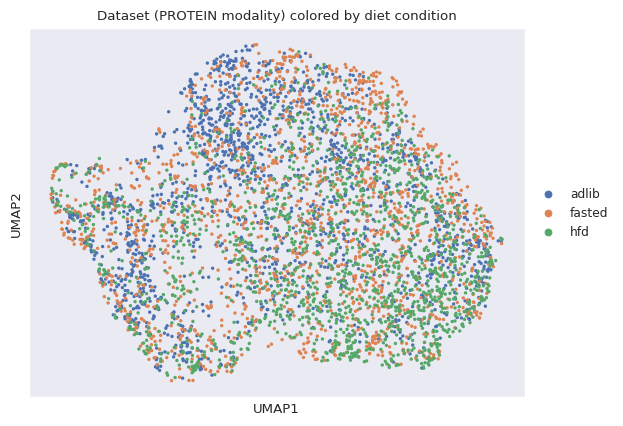

In [29]:
plot_umap(sub_prot_diet, 'cond',
          reduce_data=False,
          n_neighbors=15,
          metric='euclidean',
          min_dist=0.1,
          spread=1.0,
          addon='PROTEIN')

In [30]:
sub_prot_diet

AnnData object with n_obs × n_vars = 5009 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'
    uns: 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

We clearly do not have a UMAP space as good as the authors, we need to find better UMAP hyperparameters in hope of identifying a good combination to visualize our data.

In [31]:
def grid_search_umap(adata):
    n_neighbors_list = [15, 50, 100]
    min_dist_list = [0.01, 0.1, 0.3, 0.5]
    spread_list = [0.5, 1.0, 1.5, 10]
    metrics = ['euclidean']

    # Create all combinations
    param_grid = list(itertools.product(n_neighbors_list, min_dist_list, spread_list, metrics))

    # Run grid search
    for i, (n_neighbors, min_dist, spread, metric) in tqdm(enumerate(param_grid), total=len(param_grid)):
        print(f"Running UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}, metric={metric}")

        try:
            plot_umap(
                sub_rna_diet,
                'cond',
                reduce_data=False,
                n_neighbors=n_neighbors,
                metric=metric,
                min_dist=min_dist,
                spread=spread
            )
        except Exception as e:
            print(f"Failed with: {e}")

I ran it, it took about 30 min on my device but it revealed that none of the proposed combinations really helped. I suspect that the apparent structure at ~5k cells could be much different than that with the whole dataset.

In [32]:
# grid_search_umap(sub_rna_diet)

In [33]:
# grid_search_umap(sub_prot_diet)

## **Cross-Validation splits**

In [86]:
def create_stratified_folds(
    adata: ad.AnnData,
    n_splits: int = 5,
    label_key: str = "cond",
    random_state: int = 1234,
):
    """
    Create stratified CV folds for a single AnnData object.

    Parameters
    ----------
    adata : AnnData
        AnnData object to split.
    n_splits : int
        Number of CV folds.
    label_key : str
        Column in .obs used for stratification (e.g. "cond").
    random_state : int
        Random seed for reproducible splits.

    Returns
    -------
    folds : list of dict
        Each dict contains:
        - "fold": int
        - "train_idx": np.ndarray
        - "test_idx": np.ndarray
    """
    labels = np.array(adata.obs[label_key])
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state,
    )

    folds = []
    for fold_id, (train_idx, test_idx) in enumerate(skf.split(adata.X, labels)):
        folds.append(
            {
                "fold": fold_id,
                "train_idx": train_idx,
                "test_idx": test_idx,
            }
        )

    return folds

def run_coupling_cv(
    adata_rna: ad.AnnData,
    adata_prot: ad.AnnData,
    rna_folds,
    prot_folds,
    conditions,
    coupling_func,
    pca_key: str = "X_pca",
    label_key: str = "cond",
    coupling_kwargs: dict | None = None,
):
    """
    Run a coupling function across CV folds for UNALIGNED RNA & PROT.

    Fold k of RNA is paired with fold k of PROT (no cell-wise alignment).
    Only the training splits are used to construct the coupling.
    """
    if coupling_kwargs is None:
        coupling_kwargs = {}

    if len(rna_folds) != len(prot_folds):
        raise ValueError("rna_folds and prot_folds must have the same length (same n_splits).")

    couplings = []

    n_folds = len(rna_folds)
    for k in range(n_folds):
        rna_fold = rna_folds[k]
        prot_fold = prot_folds[k]

        rna_train_idx = rna_fold["train_idx"]
        prot_train_idx = prot_fold["train_idx"]

        # subset TRAIN data
        train_adata_RNA = adata_rna[rna_train_idx].copy()
        train_RNA_labels = np.array(train_adata_RNA.obs['cond'])
        train_adata_PROT = adata_prot[prot_train_idx].copy()
        train_PROT_labels = np.array(train_adata_PROT.obs['cond'])

        # Build train dictionaries per condition
        train_RNA_reduced = {
            i: train_adata_RNA[train_adata_RNA.obs[label_key] == cond].obsm[pca_key]
            for i, cond in enumerate(conditions)
        }
        train_PROT = {
            i: train_adata_PROT[train_adata_PROT.obs[label_key] == cond].X
            for i, cond in enumerate(conditions)
        }

        data_train = (train_PROT, train_RNA_reduced)

        # Call the coupling function on this fold's train data
        if coupling_func.__name__ == "get_coupling_fused_gw":
            # Call the FGW function with X, Y, labels
            coupling = coupling_func(
                train_adata_PROT.X,
                train_adata_RNA.obsm[pca_key],
                train_PROT_labels,
                train_RNA_labels,
                **coupling_kwargs,
            )
        else:
            coupling = coupling_func(
                data_train,
                **coupling_kwargs,
            )

        couplings.append(coupling)

    return couplings


In [87]:
rna_folds = create_stratified_folds(
    sub_rna_diet,
    n_splits=5,
    label_key="cond",
    random_state=1234,
)

prot_folds = create_stratified_folds(
    sub_prot_diet,
    n_splits=5,
    label_key="cond",
    random_state=1234,
)

In [94]:
def build_paired_matrices(
    adata_in,
    adata_out,
    label_key="cond",
    out_rep_key="X_pca",
    random_state=None,
    drop_unmatched=True,
    return_indices: bool = False,
):
    """
    For each cell in adata_in, sample one cell from adata_out that shares the same
    label (adata.obs[label_key]) and build aligned matrices X_in, Y_out.

    If `return_indices=True`, also return the *local* indices of the chosen cells
    in `adata_in` and `adata_out`.
    """
    rng = np.random.default_rng(random_state)

    # Representations
    X_in_full = adata_in.X
    Y_out_full = adata_out.obsm[out_rep_key]

    labels_in = adata_in.obs[label_key].to_numpy()
    labels_out = adata_out.obs[label_key].to_numpy()

    # Map: label -> list of indices in adata_out
    idx_by_label = {}
    for j, lab in enumerate(labels_out):
        idx_by_label.setdefault(lab, []).append(j)

    X_list, Y_list = [], []
    in_obs_names, out_obs_names = [], []
    in_idx_list, out_idx_list = [], []

    for i, lab in enumerate(labels_in):
        if lab not in idx_by_label or len(idx_by_label[lab]) == 0:
            if drop_unmatched:
                continue
            else:
                raise ValueError(f"No matching cells in adata_out for label '{lab}'")

        j = rng.choice(idx_by_label[lab])

        X_list.append(X_in_full[i])
        Y_list.append(Y_out_full[j])

        in_obs_names.append(adata_in.obs_names[i])
        out_obs_names.append(adata_out.obs_names[j])

        in_idx_list.append(i)   # local index in `adata_in`
        out_idx_list.append(j)  # local index in `adata_out`

    if len(X_list) == 0:
        raise ValueError("No pairs could be formed; check label_key and data.")

    X_in_paired = np.stack(X_list, axis=0)
    Y_out_paired = np.stack(Y_list, axis=0)

    if return_indices:
        return (
            X_in_paired,
            Y_out_paired,
            in_obs_names,
            out_obs_names,
            np.array(in_idx_list, dtype=int),
            np.array(out_idx_list, dtype=int),
        )

    return X_in_paired, Y_out_paired, in_obs_names, out_obs_names

def compute_metrics(
    coupling_list,
    method_name,
    rna_folds,
    prot_folds,
    sub_rna_diet,
    sub_prot_diet,
    labels,
):
    """
    Compute metrics over CV for one OT method. On the task of predicting
    (reduced) RNA modality based on the protein modality.
    """
    n_folds = len(rna_folds)
    per_fold_metrics = []

    print(f"\n=== Running CV for method: {method_name} ===")

    for k in range(n_folds):
        print(f"\n--- Fold {k+1}/{n_folds} ---")

        # Indices for this fold
        rna_train_idx = rna_folds[k]["train_idx"]
        rna_test_idx  = rna_folds[k]["test_idx"]
        prot_train_idx = prot_folds[k]["train_idx"]
        prot_test_idx  = prot_folds[k]["test_idx"]

        # Subset AnnData
        train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
        test_adata_RNA   = sub_rna_diet[rna_test_idx].copy()
        train_adata_PROT = sub_prot_diet[prot_train_idx].copy()
        test_adata_PROT  = sub_prot_diet[prot_test_idx].copy()

        if 'label' in method_name.lower():
            # Build training dicts
            train_RNA_reduced = {
                i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"].astype(np.float64)
                for i, cond in enumerate(labels)
            }
            train_PROT = {
                i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X.astype(np.float64)
                for i, cond in enumerate(labels)
            }
        else:
            train_RNA_reduced = {0: train_adata_RNA.obsm["X_pca"].astype(np.float64)}
            train_PROT = {0: train_adata_PROT.X.astype(np.float64)}

        data_train = (train_PROT, train_RNA_reduced)


        # Test input (PROT): build RNA/PROT pairs by label on the test set
        X_test_np, Y_test_np, in_ids, out_ids = build_paired_matrices(
            test_adata_PROT,
            test_adata_RNA,
            label_key="cond",
            out_rep_key="X_pca",
            random_state=1234,
        )

        # Convert to the types you expect
        X_test = X_test_np.astype(np.float32)
        X_test_t = torch.from_numpy(X_test).double()

        # Ground truth (RNA)
        Y_test_concatenated = Y_test_np.astype(np.float64)

        # Coupling & time for this fold and method
        coupling_for_train, time_for_train = coupling_list[k]
        if isinstance(coupling_for_train, np.ndarray):
            coupling_for_train = {0: coupling_for_train}
        else:
            coupling_for_train = {key:val.astype(np.float64) for key, val in coupling_for_train.items()}

        # Train MLP
        model, pred_log = perturbot.predict.train_mlp(data_train, coupling_for_train)

        # Predict
        model.eval()
        with torch.no_grad():
            Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)

        # Metrics for this fold (column name is method_name)
        metrics_df_pred = get_evals_preds(
            Y_test_concatenated,
            [Y_pred],
            pred_labels=[method_name],
            full=False,
        )
        metrics_series = metrics_df_pred[method_name]

        # Store fold metrics as dict
        metrics_dict = metrics_series.to_dict()
        metrics_dict["time"] = time_for_train
        per_fold_metrics.append(metrics_dict)

        print(
            f"{method_name} | fold {k}: "
            f"MSE={metrics_dict.get('MSE', np.nan):.4f}, "
            f"Pearson={metrics_dict.get('Pearson_corr', np.nan):.4f}"
        )

    # All folds for this method
    per_fold_df = pd.DataFrame(per_fold_metrics)

    # Aggregate numeric metrics across folds (mean); you can extend with std if desired
    numeric_cols = per_fold_df.select_dtypes(include=[np.number]).columns
    mean_row = per_fold_df[numeric_cols].mean().to_frame().T  # 1-row DataFrame
    std_row = per_fold_df[numeric_cols].std().to_frame().T

    # Add method name (and anything else you want to keep as metadata)
    mean_row["method"] = method_name
    std_row["method"] = method_name

    return mean_row, std_row # 1-row DataFrames

def compute_match_metrics(
    coupling_list,
    method_name,
    rna_folds,
    prot_folds,
    sub_rna_diet,
    sub_prot_diet,
    labels,
    labeled=None,
):
    """
    Compute coupling matching metrics (FOSCTTM) for ONE method across all folds.

    If `labeled=True`: coupling_list[k] = (T_dict, info),
      where T_dict[i] is the coupling for label i.

    If `labeled=False`: coupling_list[k] = (T, info),
      where T is a single matrix built on the concatenation of
      per-label training data in the order given by `labels`
      (same convention as perturbot's get_FOSCTTM_single).
    """
    if labeled is None:
        labeled = "label" in method_name.lower()

    n_folds = len(rna_folds)
    per_fold_metrics = []

    print(f"\n=== Running match metrics for method: {method_name} ===")

    for k in range(n_folds):
        print(f"\n--- Fold {k+1}/{n_folds} ---")
        print("Evaluation of coupling metrics on the training data")

        # -----------------------------
        # 1) Subset training data for this fold
        # -----------------------------
        rna_train_idx  = rna_folds[k]["train_idx"]
        prot_train_idx = prot_folds[k]["train_idx"]

        train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
        train_adata_PROT = sub_prot_diet[prot_train_idx].copy()

        # -----------------------------
        # 2) Get the coupling for this fold
        # -----------------------------
        if labeled:
            # coupling_list[k] = (T_dict, info)
            T_dict_full, info = coupling_list[k]
        else:
            # coupling_list[k] = (T, info)
            T_full, info = coupling_list[k]

            # Rebuild the per-label full training arrays to infer
            # the segmentation used when building T_full
            train_RNA_full = {
                i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond]
                   .obsm["X_pca"]
                   .astype(np.float64)
                for i, cond in enumerate(labels)
            }
            train_PROT_full = {
                i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond]
                   .X
                   .astype(np.float64)
                for i, cond in enumerate(labels)
            }

            # Precompute cumulative offsets for global indices
            n_src_by_label = [train_PROT_full[i].shape[0] for i in range(len(labels))]
            n_tgt_by_label = [train_RNA_full[i].shape[0] for i in range(len(labels))]

            src_offsets = np.cumsum([0] + n_src_by_label[:-1])
            tgt_offsets = np.cumsum([0] + n_tgt_by_label[:-1])

        # -----------------------------
        # 3) Build *paired* dicts and restrict the coupling
        # -----------------------------
        Xs_train_dict = {}
        Xt_train_dict = {}

        if labeled:
            T_dict_paired = {}
        else:
            # For single T, we will construct the index sets for slicing T_full
            global_src_idx_list = []
            global_tgt_idx_list = []

        for i, cond in enumerate(labels):
            # Per-condition AnnData
            adata_RNA_cond  = train_adata_RNA[train_adata_RNA.obs["cond"] == cond]
            adata_PROT_cond = train_adata_PROT[train_adata_PROT.obs["cond"] == cond]

            (
                Xs_label,
                Xt_label,
                in_ids,
                out_ids,
                in_idx_local,
                out_idx_local,
            ) = build_paired_matrices(
                adata_PROT_cond,
                adata_RNA_cond,
                label_key="cond",
                out_rep_key="X_pca",
                random_state=1234,
                return_indices=True,
            )

            # Store paired data (these will define the row/col order for FOSCTTM)
            Xs_train_dict[i] = Xs_label.astype(np.float64)
            Xt_train_dict[i] = Xt_label.astype(np.float64)

            if labeled:
                # T_dict_full[i] is (n_rna_cond, n_prot_cond),
                # rows/cols aligned with adata_RNA_cond / adata_PROT_cond
                T_label_full = T_dict_full[i]
                T_label_paired = T_label_full[np.ix_(in_idx_local, out_idx_local)]
                T_dict_paired[i] = T_label_paired
            else:
                # Map local indices to global indices into T_full
                base_src = src_offsets[i]
                base_tgt = tgt_offsets[i]

                global_src_idx_i = base_src + in_idx_local
                global_tgt_idx_i = base_tgt + out_idx_local

                global_src_idx_list.append(global_src_idx_i)
                global_tgt_idx_list.append(global_tgt_idx_i)

        # -----------------------------
        # 4) Compute FOSCTTM
        # -----------------------------
        if labeled:
            # Labeled: dictionary of couplings T_dict_paired
            foscttm_bary_list, median_foscttm_bary = get_FOSCTTM(
                T_dict=T_dict_paired,
                Xs_dict=Xs_train_dict,
                Xt_dict=Xt_train_dict,
                use_barycenter=True,
            )
        else:
            # Single global T: slice T_full to the paired subset
            global_src_idx = np.concatenate(global_src_idx_list)
            global_tgt_idx = np.concatenate(global_tgt_idx_list)

            T_paired = T_full[np.ix_(global_src_idx, global_tgt_idx)]

            foscttm_bary_list, median_foscttm_bary = get_FOSCTTM_single(
                T=T_paired,
                Xs_dict=Xs_train_dict,
                Xt_dict=Xt_train_dict,
                use_barycenter=True,
            )

        all_foscttm_bary = foscttm_bary_list
        mean_foscttm_bary = np.nanmean(all_foscttm_bary)

        metrics_dict = {
            "method": method_name,
            "Bary_FOSCTTM": median_foscttm_bary,
            "Mean_Bary_FOSCTTM": mean_foscttm_bary,
        }

        if np.isscalar(info):
            metrics_dict["time"] = info

        per_fold_metrics.append(metrics_dict)

        print(
            f"{method_name} | fold {k}: "
            f"Bary_FOSCTTM={median_foscttm_bary:.4f}, "
            f"Mean_Bary_FOSCTTM={mean_foscttm_bary:.4f}"
        )

    # -----------------------------
    # 5) Aggregate across folds
    # -----------------------------
    per_fold_df = pd.DataFrame(per_fold_metrics)
    numeric_cols = per_fold_df.select_dtypes(include=[np.number]).columns

    mean_row = per_fold_df[numeric_cols].mean().to_frame().T
    std_row  = per_fold_df[numeric_cols].std().to_frame().T

    mean_row["method"]  = method_name
    mean_row["labeled"] = labeled
    std_row["method"]   = method_name
    std_row["labeled"]  = labeled

    return mean_row, std_row

def coupling_time(coupling_results):
    def extract_total_time(log_dict):
        if 'time' in log_dict:
            return log_dict['time']
        total_time = 0
        found_time = False
        for key, val in log_dict.items():
            if isinstance(val, dict) and 'time' in val:
                total_time += val['time']
                found_time = True

        if found_time:
            return total_time

        return None
    coupling_times = [extract_total_time(res[1]) for res in coupling_results]
    avg_time = np.mean(coupling_times)
    std_time = np.std(coupling_times)
    print(f"\nAverage time: {avg_time:.2f} seconds")
    print(f"Standard deviation: {std_time:.2f} seconds")

In [89]:
mean_results_list = []
std_results_list = []
mean_match_results_list = []
std_match_results_list = []

## **Compute couplings with diverse methods**
(GWOT, COOT, FGWOT, with or without labels, with or without entropic regularization)

In [90]:
coupling_names = [
    "EGWOT Labeled (legw)",
    "EGWOT All (egw)",
    "EGWOT Per Label (egwper)",
    "COOT Labeled (cotl)",
    "ECOOT Labeled (ecotl)",
    "COOT All (cot)",
    "ECOOT All (ecot)",
    "Fused GW (fgw)",
]

In [91]:
#EGWOT labeled
legw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_labels_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.001},
                            )
coupling_time(legw)

running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer loop of Gromov Wasserstein has converged: False
The final regularized GW cost is: 0.027
Done running LEGWOT with ott
running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer loop of Gromov Wasserstein has converged: False
The final regularized GW cost is: 0.027
Done running LEGWOT with ott
running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer l

In [92]:
results = compute_metrics(legw,
                "EGWOT Labeled (legw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: EGWOT Labeled (legw) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 94/2000:   5%|▍         | 94/2000 [01:48<36:33,  1.15s/it, v_num=21, train_loss_epoch=2.75]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.987. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 0: MSE=5.1175, Pearson=0.2027

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 75/2000:   4%|▍         | 75/2000 [01:26<36:48,  1.15s/it, v_num=22, train_loss_epoch=2.78]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.271. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 1: MSE=5.0102, Pearson=0.2099

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 114/2000:   6%|▌         | 114/2000 [02:10<36:05,  1.15s/it, v_num=23, train_loss_epoch=2.8]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.525. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 2: MSE=5.7275, Pearson=0.2106

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 94/2000:   5%|▍         | 94/2000 [01:49<37:03,  1.17s/it, v_num=24, train_loss_epoch=2.83]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.282. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 3: MSE=5.6319, Pearson=0.2235

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 88/2000:   4%|▍         | 88/2000 [01:41<36:53,  1.16s/it, v_num=25, train_loss_epoch=2.81]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.539. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 4: MSE=6.0574, Pearson=0.1664

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.202615       0.020448        -0.004882         -0.003758  5.508905   

                 method  
0  EGWOT Labeled (legw)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.021572       0.009644         0.004538          0.004379  0.437491   

                 method  
0  EGWOT Labeled (legw)  


In [95]:
results = compute_match_metrics(legw,
                "EGWOT Labeled (legw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])



=== Running match metrics for method: EGWOT Labeled (legw) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 0: Bary_FOSCTTM=0.4985, Mean_Bary_FOSCTTM=0.4985

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 1: Bary_FOSCTTM=0.4975, Mean_Bary_FOSCTTM=0.4975

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 2: Bary_FOSCTTM=0.4955, Mean_Bary_FOSCTTM=0.4955

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 3: Bary_FOSCTTM=0.4946, Mean_Bary_FOSCTTM=0.4946

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 4: Bary_FOSCTTM=0.4952, Mean_Bary_FOSCTTM=0.4952

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM                method  labeled
0      0.496239           0.496239  EGWOT Labeled (legw)     True
   Bary_FOSCTTM  Mean_Bary_FOSCTTM                met

In [96]:
#EGWOT without labels
egw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_all_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.005},
                            )
coupling_time(egw)

running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.005
Done running EGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.005
Done running EGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.006
Done running EGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearizati

In [97]:
results = compute_metrics(egw,
                "EGWOT All (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: EGWOT All (egw) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 111/2000:   6%|▌         | 111/2000 [02:08<36:33,  1.16s/it, v_num=26, train_loss_epoch=3.72]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.723. Signaling Trainer to stop.
EGWOT All (egw) | fold 0: MSE=4.3419, Pearson=0.2207

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 83/2000:   4%|▍         | 83/2000 [01:36<37:05,  1.16s/it, v_num=27, train_loss_epoch=3.97]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.892. Signaling Trainer to stop.
EGWOT All (egw) | fold 1: MSE=4.1349, Pearson=0.1946

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 84/2000:   4%|▍         | 84/2000 [01:37<37:03,  1.16s/it, v_num=28, train_loss_epoch=3.73]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.818. Signaling Trainer to stop.
EGWOT All (egw) | fold 2: MSE=4.8659, Pearson=0.2105

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 122/2000:   6%|▌         | 122/2000 [02:21<36:16,  1.16s/it, v_num=29, train_loss_epoch=3.6]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.995. Signaling Trainer to stop.
EGWOT All (egw) | fold 3: MSE=4.6026, Pearson=0.2014

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 62/2000:   3%|▎         | 62/2000 [01:11<37:22,  1.16s/it, v_num=30, train_loss_epoch=3.86]
Monitored metric val_loss did not improve in the last 45 records. Best score: 3.074. Signaling Trainer to stop.
EGWOT All (egw) | fold 4: MSE=4.9821, Pearson=0.1567

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.196779       0.010777        -0.005844         -0.001878  4.585467   

            method  
0  EGWOT All (egw)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.024437       0.010132         0.003884          0.005658  0.353074   

            method  
0  EGWOT All (egw)  


In [98]:
results = compute_match_metrics(egw,
                "EGWOT All (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: EGWOT All (egw) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
EGWOT All (egw) | fold 0: Bary_FOSCTTM=0.4959, Mean_Bary_FOSCTTM=0.4984

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
EGWOT All (egw) | fold 1: Bary_FOSCTTM=0.4939, Mean_Bary_FOSCTTM=0.4961

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
EGWOT All (egw) | fold 2: Bary_FOSCTTM=0.5040, Mean_Bary_FOSCTTM=0.4995

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
EGWOT All (egw) | fold 3: Bary_FOSCTTM=0.4945, Mean_Bary_FOSCTTM=0.4974

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
EGWOT All (egw) | fold 4: Bary_FOSCTTM=0.5013, Mean_Bary_FOSCTTM=0.4990

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM           method  labeled
0      0.497916           0.498096  EGWOT All (egw)    False
   Bary_FOSCTTM  Mean_Bary_FOSCTTM           method  labeled
0      0.004485           0.0013

In [99]:
#EGWOT per labels
egwper = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.05},
                            )
coupling_time(egwper)

GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearizat

In [100]:
results = compute_metrics(egwper,
                "EGWOT Per Label (egwper)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: EGWOT Per Label (egw) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 58/2000:   3%|▎         | 58/2000 [01:06<36:52,  1.14s/it, v_num=31, train_loss_epoch=3.85]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.812. Signaling Trainer to stop.
EGWOT Per Label (egw) | fold 0: MSE=3.9636, Pearson=0.1545

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 46/2000:   2%|▏         | 46/2000 [00:52<37:06,  1.14s/it, v_num=32, train_loss_epoch=4.28]
Monitored metric val_loss did not improve in the last 45 records. Best score: 3.385. Signaling Trainer to stop.
EGWOT Per Label (egw) | fold 1: MSE=3.6645, Pearson=0.0999

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 48/2000:   2%|▏         | 48/2000 [00:54<37:02,  1.14s/it, v_num=33, train_loss_epoch=4.19]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.869. Signaling Trainer to stop.
EGWOT Per Label (egw) | fold 2: MSE=4.4365, Pearson=0.0976

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 75/2000:   4%|▍         | 75/2000 [01:25<36:33,  1.14s/it, v_num=34, train_loss_epoch=4.21]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.845. Signaling Trainer to stop.
EGWOT Per Label (egw) | fold 3: MSE=4.0191, Pearson=0.1047

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 78/2000:   4%|▍         | 78/2000 [01:28<36:30,  1.14s/it, v_num=35, train_loss_epoch=4.21]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.731. Signaling Trainer to stop.
EGWOT Per Label (egw) | fold 4: MSE=4.5150, Pearson=0.0991

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.111164       0.004922         0.001973          0.002582  4.119735   

                  method  
0  EGWOT Per Label (egw)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.024372       0.012822         0.006762          0.004752  0.352941   

                  method  
0  EGWOT Per Label (egw)  


In [101]:
results = compute_match_metrics(egwper,
                "EGWOT Per Label (egwper)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: EGWOT Per Label (egw) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
EGWOT Per Label (egw) | fold 0: Bary_FOSCTTM=0.4998, Mean_Bary_FOSCTTM=0.4998

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
EGWOT Per Label (egw) | fold 1: Bary_FOSCTTM=0.4989, Mean_Bary_FOSCTTM=0.4989

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
EGWOT Per Label (egw) | fold 2: Bary_FOSCTTM=0.5007, Mean_Bary_FOSCTTM=0.5007

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
EGWOT Per Label (egw) | fold 3: Bary_FOSCTTM=0.5014, Mean_Bary_FOSCTTM=0.5014

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
EGWOT Per Label (egw) | fold 4: Bary_FOSCTTM=0.5003, Mean_Bary_FOSCTTM=0.5003

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM                 method  labeled
0      0.500216           0.500216  EGWOT Per Label (egw)     True
   Bary_FOSCTTM  Mean_Bary_FOSCTTM           

In [102]:
#COOT labeled
cotl = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cotl,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={},
                            )
coupling_time(cotl)

M_0:0.2534754017386248 - 139.7444144071963
M_1:0.2769421995212729 - 241.22389660550164
M_2:0.18584888896299334 - 258.20292179647566
M:3.550214875486029 - 163.13976908603047
It 0 Delta: 0.19455415123072026  Loss: 12.74878927043788
M_0:0.24080556838997683 - 140.19802362445884
M_1:0.24612068810234447 - 241.2708074405103
M_2:0.18732410369132102 - 259.1547278689339
M:3.4297069814721324 - 163.59488328535232
It 1 Delta: 0.03699847110271847  Loss: 12.554224628358083
M_0:0.24123608217359277 - 140.17810855422826
M_1:0.24731373614881075 - 241.2594730539641
M_2:0.1859302833385721 - 259.1899162089616
M:3.4328480403132207 - 163.58286716602586
It 2 Delta: 0.02807194390118198  Loss: 12.55236159055163
M_0:0.24090142921805466 - 140.15090833296014
M_1:0.24419193023882255 - 241.25447636758798
M_2:0.18489932619999183 - 259.19658815365585
M:3.4343491668188793 - 163.58156908326532
It 3 Delta: 0.004652468338881857  Loss: 12.551393421193556
M_0:0.24076587524783663 - 140.161250642419
M_1:0.24254418613973305 - 2

In [103]:
results = compute_metrics(cotl,
                "COOT Labeled (cotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: COOT Labeled (cotl) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 147/2000:   7%|▋         | 147/2000 [02:47<35:10,  1.14s/it, v_num=36, train_loss_epoch=1.61]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.615. Signaling Trainer to stop.
COOT Labeled (cotl) | fold 0: MSE=6.4420, Pearson=0.1394

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 93/2000:   5%|▍         | 93/2000 [01:46<36:20,  1.14s/it, v_num=37, train_loss_epoch=1.56]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.253. Signaling Trainer to stop.
COOT Labeled (cotl) | fold 1: MSE=5.9777, Pearson=0.1338

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 137/2000:   7%|▋         | 137/2000 [02:36<35:31,  1.14s/it, v_num=38, train_loss_epoch=1.64]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.349. Signaling Trainer to stop.
COOT Labeled (cotl) | fold 2: MSE=7.3708, Pearson=0.0965

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 87/2000:   4%|▍         | 87/2000 [01:40<36:54,  1.16s/it, v_num=39, train_loss_epoch=1.54]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.570. Signaling Trainer to stop.
COOT Labeled (cotl) | fold 3: MSE=6.9288, Pearson=0.1052

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 138/2000:   7%|▋         | 138/2000 [02:38<35:37,  1.15s/it, v_num=40, train_loss_epoch=1.6]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.362. Signaling Trainer to stop.
COOT Labeled (cotl) | fold 4: MSE=7.2884, Pearson=0.1030

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples      MSE  \
0      0.115579       0.036368         0.001465          0.002316  6.80155   

                method  
0  COOT Labeled (cotl)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.019544       0.009485         0.003569          0.004209  0.588485   

                method  
0  COOT Labeled (cotl)  


In [104]:
results = compute_match_metrics(cotl,
                "COOT Labeled (cotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: COOT Labeled (cotl) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
COOT Labeled (cotl) | fold 0: Bary_FOSCTTM=0.4978, Mean_Bary_FOSCTTM=0.4978

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
COOT Labeled (cotl) | fold 1: Bary_FOSCTTM=0.4940, Mean_Bary_FOSCTTM=0.4940

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
COOT Labeled (cotl) | fold 2: Bary_FOSCTTM=0.4983, Mean_Bary_FOSCTTM=0.4983

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
COOT Labeled (cotl) | fold 3: Bary_FOSCTTM=0.4931, Mean_Bary_FOSCTTM=0.4931

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
COOT Labeled (cotl) | fold 4: Bary_FOSCTTM=0.4944, Mean_Bary_FOSCTTM=0.4944

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM               method  labeled
0      0.495496           0.495496  COOT Labeled (cotl)     True
   Bary_FOSCTTM  Mean_Bary_FOSCTTM               method  labe

In [151]:
import importlib
importlib.reload(perturbot.match.cot_labels)
from perturbot.match.cot_labels import get_coupling_cotl_sinkhorn

In [152]:
#ECOOT labeled 'ran by modifying the code of petubot to accept max_iter (defaul = 2000 in the original code, I used 250 here)
ecotl = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cotl_sinkhorn,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps":0.5, "max_iter":250},
                            )
coupling_time(ecotl)

calculating with eps 0.5
M_0:0.2534754017386248 - 139.7444144071963
lse step
M_1:0.2769421995212729 - 241.22389660550164
lse step
M_2:0.18584888896299334 - 258.20292179647566
lse step
M:3.568505561089226 - 163.64818866289733
lse step
It 0 Delta: 3.2251554975186077e-06  Loss: 12.946758238174148
M_0:0.25347579672025294 - 139.74440288847362
lse step
M_1:0.2769421866848156 - 241.22390703424097
lse step
M_2:0.18584890129318404 - 258.2030074415209
lse step
M:3.5685055630220273 - 163.64818885242485
lse step
It 1 Delta: 8.149072527885437e-09  Loss: 12.946759793245608
M_0:0.25347579872832743 - 139.7444028286363
lse step
M_1:0.27694218737598586 - 241.22390696538187
lse step
M_2:0.1858489017829423 - 258.20300679823566
lse step
M:3.5685055627684985 - 163.64818883282368
lse step
It 2 Delta: 1.2577165975358184e-08  Loss: 12.94675771410219
M_0:0.25347579638124645 - 139.74440289900932
lse step
M_1:0.2769421871550332 - 241.22390706688273
lse step
M_2:0.18584890090605266 - 258.2030075488391
lse step
M:3

In [153]:
results = compute_metrics(ecotl,
                "ECOOT Labeled (ecotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: ECOOT Labeled (ecotl) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 59/2000:   3%|▎         | 59/2000 [01:08<37:21,  1.15s/it, v_num=59, train_loss_epoch=4.13]
Monitored metric val_loss did not improve in the last 45 records. Best score: 3.107. Signaling Trainer to stop.
ECOOT Labeled (ecotl) | fold 0: MSE=3.9569, Pearson=0.1167

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99/2000:   5%|▍         | 99/2000 [01:53<36:27,  1.15s/it, v_num=60, train_loss_epoch=4.55]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.784. Signaling Trainer to stop.
ECOOT Labeled (ecotl) | fold 1: MSE=3.6342, Pearson=0.1446

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 50/2000:   2%|▎         | 50/2000 [00:57<37:28,  1.15s/it, v_num=61, train_loss_epoch=4.11]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.722. Signaling Trainer to stop.
ECOOT Labeled (ecotl) | fold 2: MSE=4.4120, Pearson=-0.0115

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 86/2000:   4%|▍         | 86/2000 [01:38<36:34,  1.15s/it, v_num=62, train_loss_epoch=4.36]
Monitored metric val_loss did not improve in the last 45 records. Best score: 2.816. Signaling Trainer to stop.
ECOOT Labeled (ecotl) | fold 3: MSE=4.0100, Pearson=0.0682

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 57/2000:   3%|▎         | 57/2000 [01:05<37:15,  1.15s/it, v_num=63, train_loss_epoch=4.23]
Monitored metric val_loss did not improve in the last 45 records. Best score: 3.069. Signaling Trainer to stop.
ECOOT Labeled (ecotl) | fold 4: MSE=4.4785, Pearson=-0.0274

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.058104       0.007378         0.000275         -0.004184  4.098318   

                  method  
0  ECOOT Labeled (ecotl)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.076125       0.026704         0.004962          0.006782  0.348618   

                  method  
0  ECOOT Labeled (ecotl)  


In [154]:
results = compute_match_metrics(ecotl,
                "ECOOT Labeled (ecotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: ECOOT Labeled (ecotl) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
ECOOT Labeled (ecotl) | fold 0: Bary_FOSCTTM=0.5008, Mean_Bary_FOSCTTM=0.5008

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
ECOOT Labeled (ecotl) | fold 1: Bary_FOSCTTM=0.5000, Mean_Bary_FOSCTTM=0.5000

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
ECOOT Labeled (ecotl) | fold 2: Bary_FOSCTTM=0.5008, Mean_Bary_FOSCTTM=0.5008

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
ECOOT Labeled (ecotl) | fold 3: Bary_FOSCTTM=0.5011, Mean_Bary_FOSCTTM=0.5011

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
ECOOT Labeled (ecotl) | fold 4: Bary_FOSCTTM=0.5004, Mean_Bary_FOSCTTM=0.5004

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM                 method  labeled
0      0.500623           0.500623  ECOOT Labeled (ecotl)     True
   Bary_FOSCTTM  Mean_Bary_FOSCTTM           

In [112]:
#COOT without labels
cot = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cot,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={},
                            )
coupling_time(cot)

Delta: 0.20356162241144568  Loss: 4.24182314972816
Delta: 0.05918562394522278  Loss: 4.1686490053362935
Delta: 0.0296780542228267  Loss: 4.167789951776175
Delta: 0.030184020954136713  Loss: 4.167558098195108
Delta: 0.005909552606029388  Loss: 4.167429462994069
Delta: 0.0010815331982248473  Loss: 4.167429462994069
converged at iter  5
Delta: 0.2029192087750652  Loss: 4.248043525704702
Delta: 0.06330092428242332  Loss: 4.175454569544396
Delta: 0.04471196052870291  Loss: 4.17409007753116
Delta: 0.007932648122669859  Loss: 4.1734907026207075
Delta: 0.001035013876990766  Loss: 4.1734907026207075
converged at iter  4
Delta: 0.20130031231224887  Loss: 4.262754588554352
Delta: 0.07388940211370607  Loss: 4.189303624648001
Delta: 0.03249740303901898  Loss: 4.187816386567457
Delta: 0.007510983036341616  Loss: 4.187462143075153
Delta: 0.0  Loss: 4.187462143075153
converged at iter  4
Delta: 0.20210965277709364  Loss: 4.258780909025444
Delta: 0.06330521866585032  Loss: 4.185736322936432
Delta: 0.02

In [113]:
results = compute_metrics(cot,
                "COOT All (cot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: COOT All (cot) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 143/2000:   7%|▋         | 143/2000 [03:31<45:46,  1.48s/it, v_num=41, train_loss_epoch=1.46]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.525. Signaling Trainer to stop.
COOT All (cot) | fold 0: MSE=6.5426, Pearson=0.1372

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 131/2000:   7%|▋         | 131/2000 [03:23<48:24,  1.55s/it, v_num=42, train_loss_epoch=1.36]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.187. Signaling Trainer to stop.
COOT All (cot) | fold 1: MSE=6.6973, Pearson=0.1174

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 134/2000:   7%|▋         | 134/2000 [03:25<47:43,  1.53s/it, v_num=43, train_loss_epoch=1.41]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.525. Signaling Trainer to stop.
COOT All (cot) | fold 2: MSE=7.5618, Pearson=0.0971

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 103/2000:   5%|▌         | 103/2000 [02:45<50:56,  1.61s/it, v_num=44, train_loss_epoch=1.48]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.491. Signaling Trainer to stop.
COOT All (cot) | fold 3: MSE=6.8118, Pearson=0.1202

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 212/2000:  11%|█         | 212/2000 [05:14<44:09,  1.48s/it, v_num=45, train_loss_epoch=1.36]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.326. Signaling Trainer to stop.
COOT All (cot) | fold 4: MSE=7.3726, Pearson=0.1110

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.116592       0.040605          0.00287          0.007621  6.997233   

           method  
0  COOT All (cot)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.014585       0.007435         0.005121           0.01134  0.444584   

           method  
0  COOT All (cot)  


In [114]:
results = compute_match_metrics(cot,
                "COOT All (cot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: COOT All (cot) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
COOT All (cot) | fold 0: Bary_FOSCTTM=0.5107, Mean_Bary_FOSCTTM=0.5070

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
COOT All (cot) | fold 1: Bary_FOSCTTM=0.5032, Mean_Bary_FOSCTTM=0.5013

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
COOT All (cot) | fold 2: Bary_FOSCTTM=0.5065, Mean_Bary_FOSCTTM=0.5038

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
COOT All (cot) | fold 3: Bary_FOSCTTM=0.5021, Mean_Bary_FOSCTTM=0.5016

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
COOT All (cot) | fold 4: Bary_FOSCTTM=0.5034, Mean_Bary_FOSCTTM=0.4990

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM          method  labeled
0      0.505192           0.502557  COOT All (cot)    False
   Bary_FOSCTTM  Mean_Bary_FOSCTTM          method  labeled
0      0.003498           0.003002  COOT 

In [115]:
#ECOOT without labels
ecot = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cot_sinkhorn,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps":0.5},
                            )
coupling_time(ecot)

calculating with eps 0.5
lse step
lse step
Delta: 1.5366397419165924e-06  Loss: 4.3144690557182255
lse step
lse step
Delta: 6.519659812020961e-11  Loss: 4.314469056468466
converged at iter  1
calculating with eps 0.5
lse step
lse step
Delta: 1.1496284283600038e-06  Loss: 4.321796577822877
lse step
lse step
Delta: 3.5262574110683786e-11  Loss: 4.321796578495606
converged at iter  1
calculating with eps 0.5
lse step
lse step
Delta: 1.1580103147889755e-06  Loss: 4.334664980696218
lse step
lse step
Delta: 4.5880750587645736e-11  Loss: 4.334664980565384
converged at iter  1
calculating with eps 0.5
lse step
lse step
Delta: 1.4333295091547636e-06  Loss: 4.33035455721058
lse step
lse step
Delta: 6.210495312464204e-11  Loss: 4.3303545562960535
converged at iter  1
calculating with eps 0.5
lse step
lse step
Delta: 1.1788077853113143e-06  Loss: 4.345095055644299
lse step
lse step
Delta: 1.2980508223847664e-08  Loss: 4.345095045305053
converged at iter  1

Average time: 8.84 seconds
Standard devi

In [116]:
results = compute_metrics(cot,
                "ECOOT All (ecot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: ECOOT All (ecot) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 113/2000:   6%|▌         | 113/2000 [02:17<38:17,  1.22s/it, v_num=46, train_loss_epoch=1.38]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.561. Signaling Trainer to stop.
ECOOT All (ecot) | fold 0: MSE=6.6567, Pearson=0.1312

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 96/2000:   5%|▍         | 96/2000 [01:57<38:41,  1.22s/it, v_num=47, train_loss_epoch=1.43]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.274. Signaling Trainer to stop.
ECOOT All (ecot) | fold 1: MSE=5.9892, Pearson=0.1324

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 122/2000:   6%|▌         | 122/2000 [02:28<38:09,  1.22s/it, v_num=48, train_loss_epoch=1.45]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.445. Signaling Trainer to stop.
ECOOT All (ecot) | fold 2: MSE=7.2941, Pearson=0.1040

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 167/2000:   8%|▊         | 167/2000 [03:23<37:11,  1.22s/it, v_num=49, train_loss_epoch=1.44]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.456. Signaling Trainer to stop.
ECOOT All (ecot) | fold 3: MSE=7.3316, Pearson=0.0962

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 183/2000:   9%|▉         | 183/2000 [03:44<37:10,  1.23s/it, v_num=50, train_loss_epoch=1.36]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.319. Signaling Trainer to stop.
ECOOT All (ecot) | fold 4: MSE=6.9949, Pearson=0.1215

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.117049       0.040374         0.002394          0.006234  6.853296   

             method  
0  ECOOT All (ecot)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.016292       0.006146          0.00693          0.006549  0.554188   

             method  
0  ECOOT All (ecot)  


In [117]:
results = compute_match_metrics(cot,
                "ECOOT All (ecot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: ECOOT All (ecot) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
ECOOT All (ecot) | fold 0: Bary_FOSCTTM=0.5107, Mean_Bary_FOSCTTM=0.5070

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
ECOOT All (ecot) | fold 1: Bary_FOSCTTM=0.5032, Mean_Bary_FOSCTTM=0.5013

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
ECOOT All (ecot) | fold 2: Bary_FOSCTTM=0.5065, Mean_Bary_FOSCTTM=0.5038

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
ECOOT All (ecot) | fold 3: Bary_FOSCTTM=0.5021, Mean_Bary_FOSCTTM=0.5016

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
ECOOT All (ecot) | fold 4: Bary_FOSCTTM=0.5034, Mean_Bary_FOSCTTM=0.4990

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM            method  labeled
0      0.505192           0.502557  ECOOT All (ecot)    False
   Bary_FOSCTTM  Mean_Bary_FOSCTTM            method  labeled
0      0.003498        

In [120]:
#Fused GW
def get_coupling_fused_gw(X_train, Y_train, labels_X, labels_Y, epsilon=0.001, alpha=0.99, max_iter=500):
    """
    Compute the Fused Gromov-Wasserstein coupling between X_train and Y_train
    using labels_train for the fused cost.
    """
    # -----------------------------
    # 1. Matrices de coût C1 et C2
    # -----------------------------
    # Calcul des matrices de coût quadratiques normalisées
    C1 = ot.dist(X_train, X_train, metric='euclidean')**2
    C2 = ot.dist(Y_train, Y_train, metric='euclidean')**2
    C1=C1/C1.max()
    C2=C2/C2.max()

    # -----------------------------
    # 2. Matrice de coût fused M
    # -----------------------------
    # Ici M[i,j] = 1 si labels différents, 0 sinon
    start = time.time()
    n_train = X_train.shape[0]
    m_train = Y_train.shape[0]

    # M = 1 si labels différents
    M = (labels_X[:, None] != labels_Y[None, :]).astype(float)

    print("Calcul du transport plan Fused Gromov-Wasserstein (Si alpha=1 -> GW uniquement)...")
    T = ot.gromov.entropic_fused_gromov_wasserstein(
        M, C1, C2, alpha=alpha, epsilon=epsilon, max_iter=max_iter, verbose=True
    )
    end= time.time()
    runtime = end - start
    return T, {"time": runtime}

fgw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_fused_gw,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"epsilon":0.005, "alpha":0.99, "max_iter":500},
                            )
coupling_time(fgw)

Calcul du transport plan Fused Gromov-Wasserstein (Si alpha=1 -> GW uniquement)...
It.  |Err         
-------------------
    0|4.689757e-04|
   10|3.047069e-08|
   20|1.399966e-11|
Calcul du transport plan Fused Gromov-Wasserstein (Si alpha=1 -> GW uniquement)...
It.  |Err         
-------------------
    0|4.385958e-04|
   10|5.677158e-08|
   20|3.956817e-11|
Calcul du transport plan Fused Gromov-Wasserstein (Si alpha=1 -> GW uniquement)...
It.  |Err         
-------------------
    0|4.456243e-04|
   10|6.979006e-08|
   20|5.418681e-11|
Calcul du transport plan Fused Gromov-Wasserstein (Si alpha=1 -> GW uniquement)...
It.  |Err         
-------------------
    0|4.495758e-04|
   10|5.793017e-08|
   20|4.714439e-11|
Calcul du transport plan Fused Gromov-Wasserstein (Si alpha=1 -> GW uniquement)...
It.  |Err         
-------------------
    0|4.510315e-04|
   10|2.782629e-08|
   20|1.090262e-11|

Average time: 116.25 seconds
Standard deviation: 6.93 seconds


In [122]:
results = compute_metrics(cot,
                "Fused GW (fgw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: Fused GW (fgw) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 105/2000:   5%|▌         | 105/2000 [02:04<37:30,  1.19s/it, v_num=54, train_loss_epoch=1.41]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.475. Signaling Trainer to stop.
Fused GW (fgw) | fold 0: MSE=6.5838, Pearson=0.1422

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 151/2000:   8%|▊         | 151/2000 [03:00<36:51,  1.20s/it, v_num=55, train_loss_epoch=1.35]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.222. Signaling Trainer to stop.
Fused GW (fgw) | fold 1: MSE=6.3558, Pearson=0.1141

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 171/2000:   9%|▊         | 171/2000 [03:28<37:06,  1.22s/it, v_num=56, train_loss_epoch=1.34]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.482. Signaling Trainer to stop.
Fused GW (fgw) | fold 2: MSE=7.2900, Pearson=0.1090

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 135/2000:   7%|▋         | 135/2000 [02:44<37:46,  1.22s/it, v_num=57, train_loss_epoch=1.43]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.448. Signaling Trainer to stop.
Fused GW (fgw) | fold 3: MSE=6.5034, Pearson=0.1273

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 1.1 K 
  | other params | n/a        | 20    
--------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 147/2000:   7%|▋         | 147/2000 [02:58<37:29,  1.21s/it, v_num=58, train_loss_epoch=1.45]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.401. Signaling Trainer to stop.
Fused GW (fgw) | fold 4: MSE=6.9341, Pearson=0.1266

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.123844       0.042024         0.002633          0.008345  6.733432   

           method  
0  Fused GW (fgw)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.012956       0.006212         0.004643           0.00772  0.376822   

           method  
0  Fused GW (fgw)  


In [123]:
results = compute_match_metrics(cot,
                "Fused GW (fgw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])


=== Running match metrics for method: Fused GW (fgw) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
Fused GW (fgw) | fold 0: Bary_FOSCTTM=0.5107, Mean_Bary_FOSCTTM=0.5070

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
Fused GW (fgw) | fold 1: Bary_FOSCTTM=0.5032, Mean_Bary_FOSCTTM=0.5013

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
Fused GW (fgw) | fold 2: Bary_FOSCTTM=0.5065, Mean_Bary_FOSCTTM=0.5038

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
Fused GW (fgw) | fold 3: Bary_FOSCTTM=0.5021, Mean_Bary_FOSCTTM=0.5016

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
Fused GW (fgw) | fold 4: Bary_FOSCTTM=0.5034, Mean_Bary_FOSCTTM=0.4990

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM          method  labeled
0      0.505192           0.502557  Fused GW (fgw)    False
   Bary_FOSCTTM  Mean_Bary_FOSCTTM          method  labeled
0      0.003498           0.003002  Fused

## **Train MLP to evaluate performances on obtained couplings**

In [155]:
metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE']
mean_df = pd.concat(mean_results_list, axis=0)
std_df = pd.concat(std_results_list, axis=0)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = summary_df[col].round(3).astype(str) + ' ± ' + std_df[col].round(3).astype(str)

summary_df

,Pearson_corr,Spearman_corr,Pearson_samples,Spearman_samples,MSE,method
0,0.203 ± 0.022,0.02 ± 0.01,-0.005 ± 0.005,-0.004 ± 0.004,5.509 ± 0.437,EGWOT Labeled (legw)
0,0.197 ± 0.024,0.011 ± 0.01,-0.006 ± 0.004,-0.002 ± 0.006,4.585 ± 0.353,EGWOT All (egw)
0,0.111 ± 0.024,0.005 ± 0.013,0.002 ± 0.007,0.003 ± 0.005,4.12 ± 0.353,EGWOT Per Label (egw)
0,0.116 ± 0.02,0.036 ± 0.009,0.001 ± 0.004,0.002 ± 0.004,6.802 ± 0.588,COOT Labeled (cotl)
0,0.117 ± 0.015,0.041 ± 0.007,0.003 ± 0.005,0.008 ± 0.011,6.997 ± 0.445,COOT All (cot)
0,0.117 ± 0.016,0.04 ± 0.006,0.002 ± 0.007,0.006 ± 0.007,6.853 ± 0.554,ECOOT All (ecot)
0,0.124 ± 0.013,0.042 ± 0.006,0.003 ± 0.005,0.008 ± 0.008,6.733 ± 0.377,Fused GW (fgw)
0,0.058 ± 0.076,0.007 ± 0.027,0.0 ± 0.005,-0.004 ± 0.007,4.098 ± 0.349,ECOOT Labeled (ecotl)


In [156]:
metrics = ['Bary_FOSCTTM', 'Mean_Bary_FOSCTTM']
mean_df = pd.concat(mean_match_results_list, axis=0)
std_df = pd.concat(std_match_results_list, axis=0)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = summary_df[col].round(3).astype(str) + ' ± ' + std_df[col].round(3).astype(str)

summary_df

,Bary_FOSCTTM,Mean_Bary_FOSCTTM,method,labeled
0,0.496 ± 0.002,0.496 ± 0.002,EGWOT Labeled (legw),True
0,0.498 ± 0.004,0.498 ± 0.001,EGWOT All (egw),False
0,0.5 ± 0.001,0.5 ± 0.001,EGWOT Per Label (egw),True
0,0.495 ± 0.002,0.495 ± 0.002,COOT Labeled (cotl),True
0,0.505 ± 0.003,0.503 ± 0.003,COOT All (cot),False
0,0.505 ± 0.003,0.503 ± 0.003,ECOOT All (ecot),False
0,0.505 ± 0.003,0.503 ± 0.003,Fused GW (fgw),False
0,0.501 ± 0.0,0.501 ± 0.0,ECOOT Labeled (ecotl),True


## **Coupling matrices visualization**

In [139]:
import scipy.sparse

def _safe_name(name: str) -> str:
    """Make a filesystem-friendly name from a method string."""
    return (
        name.lower()
            .replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
            .replace("/", "_")
    )

def plot_global_coupling_all_folds(coupling_list, method_name, max_display=500, save_dir="."):
    """
    For a global/unlabeled method (coupling_list[fold] = (T, info)):
    create one figure with subplots for all folds.
    """
    n_folds = len(coupling_list)

    fig, axes = plt.subplots(
        1, n_folds,
        figsize=(4 * n_folds, 4),
        squeeze=False
    )
    axes = axes[0]

    for fold in range(n_folds):
        ax = axes[fold]
        T = coupling_list[fold][0]
        if hasattr(T, "cpu"):
            T = T.cpu().numpy()

        # Determine vmin and vmax for colorbar to enhance visibility of small values
        vmin_val = 0
        non_zero_vals = T[T > 0]
        if len(non_zero_vals) > 0:
            vmax_val = np.quantile(non_zero_vals, 0.995)  # Use 99.5th percentile of non-zero values
            if vmax_val == 0:  # Fallback if percentile is 0 due to extreme smallness
                vmax_val = non_zero_vals.max() if non_zero_vals.max() > 0 else 1e-8
        else:
            vmax_val = 1e-8  # Default to a small positive if all values are zero

        if max_display is None:
            ds = T.shape[0]
            dt = T.shape[1]
        else:
            ds = min(T.shape[0], max_display)
            dt = min(T.shape[1], max_display)
        P_disp = T[:ds, :dt]

        im = ax.imshow(
            P_disp,
            cmap="magma",
            vmin=vmin_val,
            vmax=vmax_val,
            aspect='equal'
        )
        ax.set_xticks([]) # Remove x-tick labels
        ax.set_yticks([]) # Remove y-tick labels
        if (fold == n_folds - 1):
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Fold {fold}\n{ds}x{dt}", fontsize=10)

    fig.suptitle(f"{method_name} — All Folds", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(save_dir, exist_ok=True)
    fname = f"{_safe_name(method_name)}.pdf"
    path = os.path.join(save_dir, fname)
    plt.savefig(path, dpi=150)
    plt.show()

    print(f"Saved: {path}")

def plot_combined_labeled_coupling_all_folds(coupling_list, method_name, labels, max_display=500, save_dir="."):
    """
    For a labeled method (coupling_list[fold] = (T_dict, info)):
    create one figure with subplots for all folds, combining all label couplings into one block-diagonal matrix.
    """
    n_folds = len(coupling_list)

    fig, axes = plt.subplots(
        1, n_folds,
        figsize=(4 * n_folds, 4),
        squeeze=False
    )
    axes = axes[0]  # row of axes

    for fold in range(n_folds):
        ax = axes[fold]
        T_dict = coupling_list[fold][0]  # This is a dict like {0: P_adlib, 1: P_fasted, ...}

        # Get all coupling matrices in order of labels
        coupling_matrices = [T_dict[i] for i in range(len(labels)) if i in T_dict]

        # Check if any matrices are found. If not, set axis invisible
        if not coupling_matrices:
            ax.set_visible(False)
            continue

        # Combine coupling matrices into a block-diagonal matrix
        combined_P = scipy.sparse.block_diag(coupling_matrices).toarray()

        P = combined_P
        if hasattr(P, "cpu"):
            P = P.cpu().numpy()

        # Determine vmin and vmax for colorbar to enhance visibility of small values
        vmin_val = 0
        non_zero_vals = P[P > 0]
        if len(non_zero_vals) > 0:
            vmax_val = np.quantile(non_zero_vals, 0.995)  # Use 99.5th percentile of non-zero values
            if vmax_val == 0:  # Fallback if percentile is 0 due to extreme smallness
                vmax_val = non_zero_vals.max() if non_zero_vals.max() > 0 else 1e-8
        else:
            vmax_val = 1e-8  # Default to a small positive if all values are zero

        if max_display is None:
            ds = P.shape[0]
            dt = P.shape[1]
        else:
            ds = min(P.shape[0], max_display)
            dt = min(P.shape[1], max_display)
        P_disp = P[:ds, :dt]

        im = ax.imshow(
            P_disp,
            cmap="magma",
            vmin=vmin_val,
            vmax=vmax_val,
            aspect='equal'
        )
        ax.set_xticks([])
        ax.set_yticks([])
        if (fold == n_folds - 1):
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Fold {fold}\n{P.shape[0]}x{P.shape[1]}", fontsize=10)  # Show full dimensions

    fig.suptitle(f"{method_name} — Combined Labeled Couplings", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(save_dir, exist_ok=True)
    fname = f"{_safe_name(method_name)}_combined_labeled.pdf"
    path = os.path.join(save_dir, fname)
    plt.savefig(path, dpi=150)
    plt.show()

    print(f"Saved: {path}")

In [ ]:
print("\n=== VISUALIZATION OF COUPLING MATRICES - ALL FOLDS IN SUBPLOTS ===\n")

save_dir = "./diet_coupling_plots"

# Global / full-matrix methods
global_coupling_lists = [fgw[:1]]
global_coupling_names = [
    "Fused GW (fgw)",
]

for c_list, name in zip(global_coupling_lists, global_coupling_names):
    print(f"\n{name}: plotting all folds...")
    plot_global_coupling_all_folds(
        coupling_list=c_list,
        method_name=name,
        max_display=None,
        save_dir=save_dir,
    )

In [ ]:
# Labeled methods
labeled_coupling_lists = [legw[:1], ecotl[:1]]
labeled_coupling_names = [
    "EGWOT Labeled (legw)",
    "ECOOT Labeled (ecotl)",
]

for c_list, name in zip(labeled_coupling_lists, labeled_coupling_names):
    print(f"\n{name} - Combined Labeled Couplings: plotting all folds...")
    plot_combined_labeled_coupling_all_folds(
        coupling_list=c_list,
        method_name=name,
        labels=CONDITIONS,
        max_display=None,
        save_dir=save_dir,
    )